In [1]:
import random, tqdm, gym
from gym.utils import seeding
from gym.spaces.discrete import Discrete
from gym.spaces import Box

import numpy as np
import torch as th
import matplotlib.pyplot as mp

# Relational Deep Reinforcement Learning
The core idea behind RRL is to combine reinforcement learning with relational learning or Inductive
Logic Programming, by **representing states, actions and policies using a first order (or relational)
language**.

This notebook covers an RL task called Box-World from [[1]](https://arxiv.org/pdf/1806.01830.pdf), that explicitly targets relational reasoning, and demonstrates that agents with a capacity to produce relational representations using a **non-local computation based on attention** exhibit interesting generalization behaviors compared to those that do not.

We can apply the agent to a difficult problem – the StarCraft II minigames – and achieve state-of-the-art performance on six minigames.

<img src="../graphics/Box-World.png" />

                Box-World and StarCraft II tasks demand reasoning about entities and their relations.

- Moving from a propositional to a relational representation facilitates **generalization over goals, states, and actions**, exploiting knowledge learnt during an earlier learning phase.
- A relational language also facilitates the use of background knowledge. Background knowledge can be provided by logical facts and rules relevant to the learning problem.

In Box-World, one could use the predicate **above(S, A, B)** to indicate that **block A *is above* block B in state *S*** when specifying background knowledge.

Such predicates can then be
used during learning for blocks C and D, for example.


**The representational language, background,
and assumptions form the inductive bias**, which guides (and restricts) the search for good policies.
The language (or declarative) bias determines the way concepts can be represented.

<img src="../graphics/RDRL.png" />

## BoxWorld
Box-World is a perceptually simple but combinatorially complex environment that requires abstract
relational reasoning and planning. It consists of a **12×12 pixel room** with **keys and boxes randomly
scattered**. The room also contains an agent, represented by a single dark gray pixel, which can move
in four directions: up, down, left, right.

Keys are represented by a single colored pixel. The agent can pick up a loose key (i.e., one not
adjacent to any other colored pixel) by walking over it. Boxes are represented by two adjacent colored
pixels – the pixel on the right represents the box’s lock and its color indicates which key can be used
to open that lock; the pixel on the left indicates the content of the box which is inaccessible while
the box is locked.

To collect the content of a box the agent must first collect the key that opens the box (the one
that matches the lock’s color) and walk over the lock, which makes the lock disappear. At this point
the content of the box becomes accessible and can be picked up by the agent. Most boxes contain
keys that, if made accessible, can be used to open other boxes. One of the boxes contains a gem,
represented by a single white pixel. The goal of the agent is to collect the gem by unlocking the
box that contains it and picking it up by walking over it. Keys that an agent has in possession are
depicted in the input observation as a pixel in the top-left corner.

In each level there is a unique sequence of boxes that need to be opened in order to reach the gem.
Opening one wrong box (a distractor box) leads to a dead-end where the gem cannot be reached
and the level becomes unsolvable.

There are three user-controlled parameters that contribute to
the difficulty of the level: 
- the number of boxes in the path to the goal (solution length);
- the number of distractor branches;
- the length of the distractor branches.

In general, the task is computationally difficult for a few reasons:
- A key can only be used once, so the agent must be able to reason about whether a particular box is along a distractor branch or along the solution path. 

- Keys and boxes appear in random locations in the room, emphasising a capacity to reason about keys and boxes based on their abstract relations, rather than based on their spatial positions.

In [2]:
agent_color = [128, 128, 128]

action_space = {
    0: (-1, 0),
    1: (1,  0),
    2: (0, -1),
    3: (0,  1)
}

goal_color = [255, 255, 255]
grid_color = [220, 220, 220]

colors = {0: [  0,   0,   0],
          1: [230, 190, 255],
          2: [170, 255, 195],
          3: [255, 250, 200],
          4: [255, 216, 177],
          5: [250, 190, 190],
          6: [240,  50, 230],
          7: [145,  30, 180],
          8: [ 67,  99, 216],
          9: [ 66, 212, 244],
          10:[ 60, 180,  75],
          11:[191, 239,  69],
          12:[255, 255,  25],
          13:[245, 130,  49],
          14:[230,  25,  75],
          15:[128,   0,   0],
          16:[154,  99,  36],
          17:[128, 128,   0],
          18:[ 70, 153, 144],
          19:[  0,   0, 117]}

In [3]:
def sampling_pairs(pairs, n=12):
    possibilities = set(range(1, n*(n-1)))
    keys,locks = [],[]
    for k in range(pairs):
        key = random.sample(possibilities, 1)[0]
        key_x, key_y = key//(n-1), key%(n-1)
        
        lock_x, lock_y = key_x, key_y + 1
        
        to_remove = [key_x * (n-1) + key_y] + \
                    [key_x * (n-1) + i + key_y for i in range(1, min(2, n - 2 - key_y) + 1)] + \
                    [key_x * (n-1) - i + key_y for i in range(1, min(2, key_y) + 1)]

        possibilities -= set(to_remove)
        
        keys.append([key_x, key_y])
        locks.append([lock_x, lock_y])
        
    agent_xy = random.sample(possibilities, 1)
    possibilities -= set(agent_xy)
    first_key = random.sample(possibilities, 1)

    agent_xy = np.array([agent_xy[0]//(n-1), agent_xy[0]%(n-1)])
    first_key = first_key[0]//(n-1), first_key[0]%(n-1)
    return keys, locks, first_key, agent_xy

def generate(n=12, goal_length=3, num_distractor=2, distractor_length=2, seed=None, verbose=False):
    if seed is not None: random.seed(seed)

    world_dic = {}
    world = np.ones((n, n, 3)) * 220
    goal_colors = random.sample(range(len(colors)), goal_length - 1)
    
    distractor_possible_colors = [color for color in range(len(colors)) if color not in goal_colors]
    distractor_colors = [random.sample(distractor_possible_colors, distractor_length) for k in range(num_distractor)]
    distractor_roots  = random.choices(range(goal_length - 1), k=num_distractor)
    keys, locks, first_key, agent_xy = sampling_pairs(goal_length - 1 + distractor_length * num_distractor, n)

    # create the goal path
    for i in range(1, goal_length):
        if i == goal_length - 1: color = goal_color  # the final key is white
        else: color = colors[goal_colors[i]]
        
        banner = 'placed a key with color {} on position {}, corresponding lock at {} with color {}'
        if verbose: print(banner.format(color, keys[i-1], locks[i-1], colors[goal_colors[i-1]]))
        world[ keys[i-1][0],  keys[i-1][1]] = np.array(color)
        world[locks[i-1][0], locks[i-1][1]] = np.array(colors[goal_colors[i-1]])

    # keys[0] is an orphand key, so skip it
    world[first_key[0], first_key[1]] = np.array(colors[goal_colors[0]])
    banner = 'placed the first key with color {} on position {}'
    if verbose: print(banner.format(goal_colors[0], first_key))

    # place distractors
    for i, (distractor_color, root) in enumerate(zip(distractor_colors, distractor_roots)):
        key_distractor = keys[goal_length-1 + i*distractor_length: goal_length-1 + (i+1)*distractor_length]
        color_lock = colors[goal_colors[root]]
        color_key = colors[distractor_color[0]]
        world[key_distractor[0][0], key_distractor[0][1] + 1] = np.array(color_lock)
        world[key_distractor[0][0], key_distractor[0][1]] = np.array(color_key)
        for k, key in enumerate(key_distractor[1:]):
            color_lock = colors[distractor_color[k-1]]
            color_key = colors[distractor_color[k]]
            world[key[0], key[1]] = np.array(color_key)
            world[key[0], key[1]+1] = np.array(color_lock)

    # place the agent
    world[agent_xy[0], agent_xy[1]] = np.array(agent_color)
    return world, keys, locks, first_key, agent_xy

def update_color(world, previous_agent_loc, new_agent_loc):
        world[previous_agent_loc[0], previous_agent_loc[1]] = grid_color
        world[new_agent_loc[0], new_agent_loc[1]] = agent_color

def is_empty(room):
    return np.array_equal(room, grid_color) or np.array_equal(room, agent_color)

In [4]:
class BoxWorld(gym.Env):
    def __init__(self, n, goal_length, num_distractor, distractor_length, max_steps=2**10):
        self.goal_length = goal_length
        self.num_distractor = num_distractor
        self.distractor_length = distractor_length
        self.n = n
        self.pairs = goal_length - 1 + distractor_length * num_distractor

        self.step_cost  = 1e-1
        self.reward_gem = 10
        self.reward_key = 0

        self.viewer = None
        self.max_steps = max_steps
        self.action_space = Discrete(len(action_space))
        self.observation_space = Box(low=0, high=255, shape=(n, n, 3), dtype=np.uint8)

        self.owned_key = grid_color

        self.np_random_seed = None
        self.reset()

    def seed(self, seed=None):
        self.np_random_seed = seed
        return [seed]

    def save(self):
        np.save('box-world_{}.npy'.format(str(uuid.uuid4())[:8]))

    def step(self, action, verbose=False):
        self.num_env_steps += 1

        change = action_space[action]
        new_position = self.agent_xy + change
        current_position = self.agent_xy.copy()

        reward = -self.step_cost
        terminal = self.num_env_steps == self.max_steps

        if np.any(new_position < 0) or np.any(new_position >= self.n):
            possible_move = False
        elif np.array_equal(new_position, [0, 0]):
            possible_move = False
        elif is_empty(self.world[new_position[0], new_position[1]]):
            # no key, no lock
            possible_move = True
        elif new_position[1] == 0 or is_empty(self.world[new_position[0], new_position[1]-1]):
            # it's a key
            if is_empty(self.world[new_position[0], new_position[1]+1]):
                # key is not locked
                possible_move = True
                self.owned_key = self.world[new_position[0], new_position[1]].copy()
                self.world[0,0] = self.owned_key
                if np.array_equal(self.world[new_position[0], new_position[1]], goal_color):
                    # goal reached
                    reward += self.reward_gem
                    terminal = True
                else:
                    reward += self.reward_key
            else:
                possible_move = False
        else:
            # it's a lock
            if np.array_equal(self.world[new_position[0], new_position[1]], self.owned_key):
                # the lock matches the key
                possible_move = True
            else:
                possible_move = False
                banner = 'lock color is {}, but owned key is {}'
                if verbose: print(banner.format(self.world[new_position[0], new_position[1]], self.owned_key))

        if possible_move:
            self.agent_xy = new_position
            update_color(self.world, previous_agent_loc=current_position, new_agent_loc=new_position)

        metadata = {}
        return self.world, reward, terminal, metadata

    def reset(self):
        args = generate(n=self.n, goal_length=self.goal_length,
                        num_distractor=self.num_distractor,
                        distractor_length=self.distractor_length,
                        seed=self.np_random_seed)
                
        self.world, self.keys, self.locks, self.first_key, self.agent_xy = args

        self.num_env_steps = 0
        return self.world

    def render(self, mode='human'):
        img = self.world.astype(np.uint8)
        if mode == 'human':
            mp.imshow(img, vmin=0, vmax=255, interpolation='none')
            mp.show()
        else: return img
        
    def extract_objects(self, feature_maps):
        objects = [list(self.agent_xy)] + self.keys + self.locks
        return th.stack([feature_maps[...,x,y] for x,y in objects], dim=1)

In [5]:
# execute only if run as a script
env = BoxWorld(n=12, goal_length=3, num_distractor=2, distractor_length=1)
state = env.reset()

(12, 12, 3)


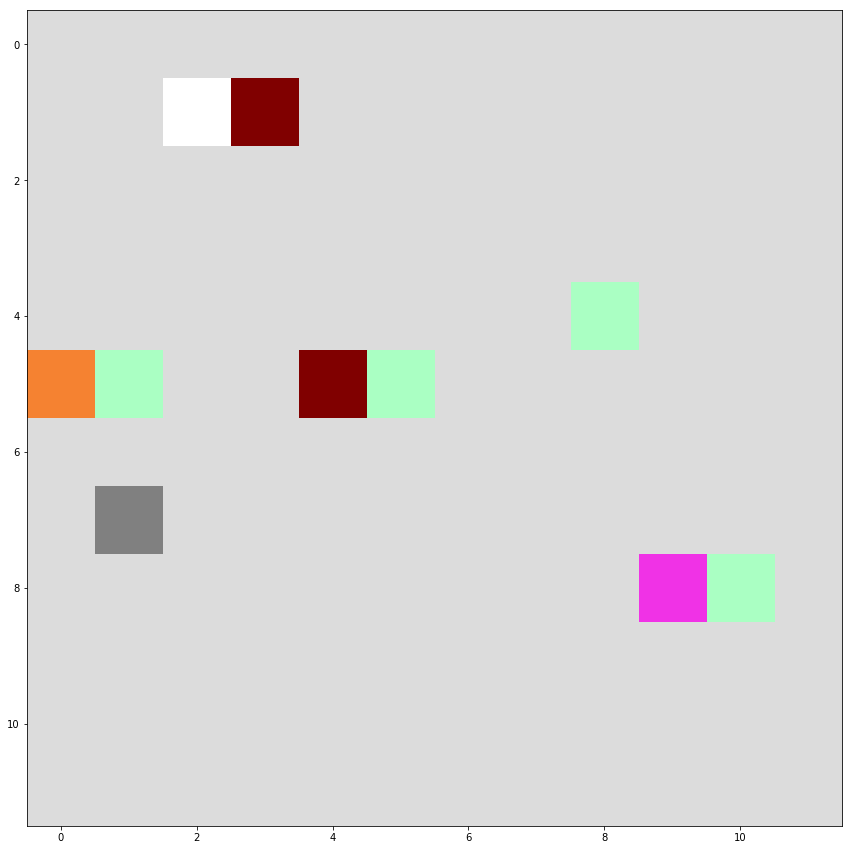

In [6]:
print(state.shape)
mp.figure(figsize=(15,15))
env.render()

## Agent Architecture

- The input observation is first processed through two convolutional layers with 12 and 24 kernels, 2 × 2 kernel sizes and a stride of 1, followed by a rectified linear unit (ReLU) activation function.
- The output is tagged with two extra channels indicating the spatial position (x and y) of each cell in the feature map using evenly spaced values between −1 and 1. 
- This is then passed to the relational module (described above) consisting of a variable number of stacked MHDPA blocks, using shared weights. 
- The output of the relational module is aggregated using feature-wise max-pooling across space (i.e., pooling a n × n × k tensor to a k-dimensional vector)
- This is then finally passed to a small MLP to produce policy logits (normalized and used as multinomial distribution from which the action was sampled) and a baseline scalar V.

The baseline control agent replaces the MHDPA blocks with a variable number of residual convolution blocks.

<img src="../graphics/MHDPA.png" />

### Extracting Entities
When dealing with unstructured inputs – e.g. RGB pixels – we need a mechanism to represent the
relevant entities.

We decide to make a minimal assumption that entities are things located in a particular point in space. We use a convolutional neural network (CNN) to parse pixel inputs into k feature maps of size n×n, where k is the number of output channels of the CNN. 

We then concatenate x and y coordinates to each k-dimensional pixel feature-vector to indicate the pixel’s position in the map. We treat the resulting n 2 pixel-feature vectors as the set of entities by compiling them into a 
n^2 × k matrix E. This provides an efficient and flexible way to learn representations of the relevant entities, while being agnostic to what may constitute an entity for the particular problem at hand.

### Multihead Dot-Product Attention
We start by assuming that we already have a set of entities for which interactions must be computed. We consider **multi-head dot-product attention (MHDPA)**, or *self-attention* [[2]](https://arxiv.org/pdf/1706.03762.pdf), as the operation that computes interactions between these entities.

For N entities, MHDPA projects each entity i’s state vector into *query, key, and value* vector representations, respectively, whose activities are subsequently normalized to have zero mean and unit variance using the method from [[3]](https://arxiv.org/pdf/1607.06450.pdf). 


Each query is compared to all entities’ keys via a dot-product, to compute unnormalized saliencies. These are normalized into weights and put through a softmax layer. For each entity, the cumulative interactions are computed by the weighted mixture of all entities’ value vectors. This can be compactly computed using matrix multiplications:

In [7]:
keys = env.keys
keys

[[5, 4], [1, 2], [8, 9], [5, 0]]

In [8]:
locks = env.locks
locks

[[5, 5], [1, 3], [8, 10], [5, 1]]

In [9]:
agent = [list(env.agent_xy)]
agent

[[7, 1]]

In [10]:
objects = agent + keys + locks
print(len(objects),'objects:',objects)

9 objects: [[7, 1], [5, 4], [1, 2], [8, 9], [5, 0], [5, 5], [1, 3], [8, 10], [5, 1]]


In [11]:
def extract_objects(xys, feature_maps):
    return th.stack([feature_maps[...,x,y] for x,y in xys], dim=1)

In [12]:
vex = extract_objects(objects, th.randn(1,32,12,12))
vex.shape

torch.Size([1, 9, 32])

### Relational Module
The output of the relational module is aggregated using feature-wise max-pooling across space (i.e., pooling a n × n × k tensor to a k-dimensional vector), and finally passed to a small MLP to produce policy logits (normalized and
used as multinomial distribution from which the action was sampled) and a baseline scalar V .
Our baseline control agent replaces the MHDPA blocks with a variable number of resid

In [13]:
from torch.nn.modules.transformer import MultiheadAttention

class RelationalModule(th.nn.Module):
    def __init__(self, ch=2048, nhead=8, dropout=0.1):
        super().__init__()
        self.self_atntn = MultiheadAttention(24, nhead)
        self.layer_norm = th.nn.LayerNorm(ch)
        self.dropout = th.nn.Dropout(dropout)

    def forward(self, objects, feature_maps=None):
        if not isinstance(objects, list): vex = objects
        else: vex = extract_objects(objects, feature_maps)
                
        _= self.self_atntn(vex,vex,vex)[0]
        _= vex + self.dropout(_)
        _= self.layer_norm(_)
        return _

In [14]:
class RRLModule(th.nn.Module):
    def __init__(self, h1=[12,24], h2=256, actions=4):
        super().__init__()
        
        self.conv1 = th.nn.Sequential(
        th.nn.Conv2d(3, h1[0], kernel_size=2, stride=1, padding=1), th.nn.ReLU(),
        th.nn.Conv2d(h1[0],h1[1], kernel_size=2, stride=1, padding=1), th.nn.ReLU())
        nfeats = self.conv1.forward(th.Tensor(1,3,12,12)).size(1)

        self.relm = RelationalModule(nfeats)
        
        self.conv2 = th.nn.Sequential(
        th.nn.Linear(nfeats, h2), th.nn.ReLU(),
        th.nn.Linear(    h2, h2), th.nn.ReLU(),
        th.nn.Linear(    h2, h2), th.nn.ReLU(),
        th.nn.Linear(    h2, h2), th.nn.ReLU())
        
        self.V, self.Pi = th.nn.Linear(h2,1), th.nn.Linear(h2, actions)
        
    def feature_maps(self, x):
        _= self.conv1(x)
        return _
    
    def __call__(self,x,objects):
        _= self.feature_maps(x)
        _= self.relm(objects,_)
        _= th.max(_,dim=1)[0]
        _= self.conv2(_)
        
        v,pi = self.V(_),self.Pi(_)
        return v,pi

In [15]:
rrl_module = RRLModule()

In [16]:
v,pi = rrl_module(th.randn(1,3,12,12),objects)

In [17]:
v.size()

torch.Size([1, 1])

In [18]:
pi.size()

torch.Size([1, 4])

In [19]:
state.shape

(12, 12, 3)

In [20]:
test_inp = th.from_numpy(state.swapaxes(0,1).swapaxes(0,-1)).float().unsqueeze(0)
test_inp.size()

torch.Size([1, 3, 12, 12])

In [21]:
test_out = rrl_module(test_inp, objects)
test_out

(tensor([[-0.0332]], grad_fn=<AddmmBackward>),
 tensor([[-0.0740, -0.0388, -0.0677, -0.0252]], grad_fn=<AddmmBackward>))

In [22]:
stochastic_policy = lambda:np.random.randint(0,len(action_space))
states, actions, rewards, sprimes, terminals = [],[],[],[],[]

In [23]:
episodes = 2**5
for _ in tqdm.tqdm_notebook(range(episodes)):
    state = env.reset()
    for _ in range(env.max_steps):
        states.append(state)
        action = stochastic_policy()
        actions.append(action)
        sprime,reward,terminal,_ = env.step(action)
        sprimes.append(sprime)
        rewards.append(reward)
        terminals.append(int(terminal))
        if terminal: break

In [24]:
S = np.asarray(states)
S.shape

(30959, 12, 12, 3)

In [25]:
A = np.asarray(actions).reshape(-1,1)
A.shape

(30959, 1)

In [26]:
R = np.asarray(rewards).reshape(-1,1)
R.shape

(30959, 1)

In [27]:
S_= np.asarray(sprimes)
S_.shape

(30959, 12, 12, 3)

In [28]:
T = np.asarray(terminals).reshape(-1,1)
T.shape

(30959, 1)

In [29]:
from rl.agents import Agent
from rl.memory.short_term import ShortTerm
from rl.policy.categorical import Categorical
from rl.util import compute_returns, estimate_advantage

### Proximal Policy Optimization

In [30]:
class PPO(Agent):
    def __init__(self, model, optim, lossfn, memory, policy, device=th.device('cpu'), *args, **kwargs):
        super().__init__()
        self.device = device
        self.model = model
        self.optim = optim
        self.lossfn = lossfn
        self.memory = memory
        self.policy = policy

    def memorize(self, reward, terminal):
        self.memory.retain(value=self.state_value.squeeze(),
                           logprob=self.logprob,
                           reward=reward,
                           terminal=terminal)

    def __call__(self, state, objects):
        self.state_value, logits = self.model(state, objects)
        self.action, self.logprob, self.entropy = self.policy(logits)
        return self.state_value, self.action

    def update(self, sprime, oprime, clip_param=1e-2, *args, **kwargs):
        values, logprobs  = th.tensor(self.memory.values), th.tensor(self.memory.logprobs).float()
        rewards,terminals = self.memory.rewards, self.memory.terminals

        state_value,_ = self.model(sprime, oprime)
        
        values = values.view(-1,1)
        state_value = state_value.view(-1,1)
      
        returns = estimate_advantage(state_value, values, rewards, terminals)
        returns = th.cat(returns).detach()
        advantage = returns - values
        
        ratio = (self.logprob - logprobs).exp()
        surr1 = ratio * advantage
        surr2 = th.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

        ploss = -th.min(surr1, surr2).mean()
        vloss = (returns - values).pow(2).mean()

        loss = vloss + ploss

        self.optim.zero_grad()
        loss.backward()
        self.optim.step()

        self.memory.wipe()
        return loss.item()

In [31]:
model  = RRLModule()
optim  = th.optim.Adam(model.parameters(), amsgrad=True, lr=1e-3)
lossfn = th.nn.MSELoss()
memory = ShortTerm()
policy = Categorical()

agent = PPO(model, optim, lossfn, memory, policy)

In [32]:
preprocess = lambda x:th.from_numpy(x.swapaxes(0,1).swapaxes(0,-1)).float().unsqueeze(0)
losses,returns = [],[]
episodes = 2**8
for episode in tqdm.tqdm_notebook(range(episodes)):
    state = env.reset()
    cummulative = 0
    for _ in range(env.max_steps):
        input = preprocess(state)
        
        objects= env.extract_objects(agent.model.feature_maps(input))
        state_value, action = agent(input, objects)
        sprime,reward,terminal,_ = env.step(action)
        oprime = env.extract_objects(agent.model.feature_maps(preprocess(sprime)))
        
        agent.memory.retain(reward, terminal)
        cummulative += reward
        if terminal: break
            
    returns.append(cummulative)
    loss = agent.update(preprocess(sprime), oprime)
    losses.append(loss)

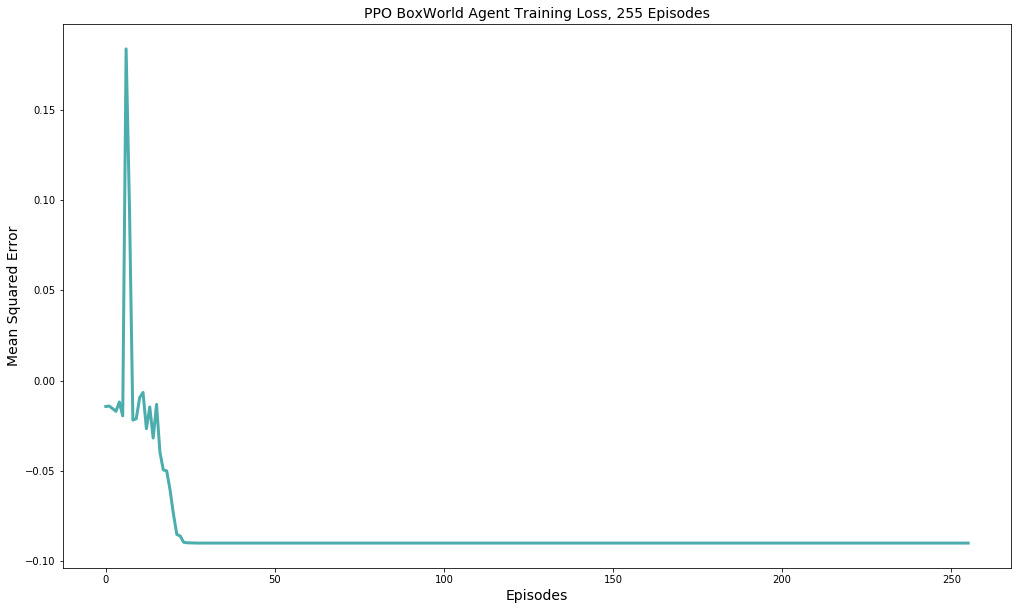

In [33]:
mp.figure(figsize=(17,10))
mp.title('PPO BoxWorld Agent Training Loss, {} Episodes'.format(episode), size=14)
mp.xlabel('Episodes', size=14),mp.ylabel('Mean Squared Error', size=14)
mp.plot(losses, lw=3, color='darkcyan', alpha=7e-1)
mp.show()